# Credit Card Approval Prediction

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV

In [2]:
# read dataset

df_app_record = pd.read_csv("./Dataset/application_record.csv")
df_credit_record = pd.read_csv("./Dataset/credit_record.csv")

In [3]:
df_credit_record['STATUS'].value_counts()

C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: STATUS, dtype: int64

In [4]:
df_app_record.shape, df_credit_record.shape

((438557, 18), (1048575, 3))

In [5]:
len(df_app_record['ID'].unique()), len(df_credit_record['ID'].unique())

(438510, 45985)

In [6]:
df_app_record.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [7]:
df_credit_record.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


### EDA on CreditRecord

<pre>
0: 1-29 days past due 
1: 30-59 days past due 
2: 60-89 days overdue 
3: 90-119 days overdue 
4: 120-149 days overdue 
5: Overdue or bad debts, write-offs for more than 150 days 
C: paid off that month 
X: No loan for the month
</pre>

In [8]:
# STATUS
df_credit_record['STATUS'].replace({'0': 1, '1':0, '2':0, '3':0, '4': 0, '5': 0, 'C':1,  'X':0}, inplace=True) #
df_credit_record['STATUS'].value_counts()

1    825151
0    223424
Name: STATUS, dtype: int64

In [9]:
df_credit_record['STATUS'] = df_credit_record['STATUS'].astype('int')
df_credit_record.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype
---  ------          --------------    -----
 0   ID              1048575 non-null  int64
 1   MONTHS_BALANCE  1048575 non-null  int64
 2   STATUS          1048575 non-null  int64
dtypes: int64(3)
memory usage: 24.0 MB


In [10]:
# Credit History Months
months_bal_df = abs(df_credit_record.groupby('ID')['MONTHS_BALANCE'].min().reset_index())
months_bal_df.rename(columns={'MONTHS_BALANCE': 'CREDIT_HISTORY_MONTHS'}, inplace=True)
months_bal_df.head()

,ID,CREDIT_HISTORY_MONTHS
0,5001711,3
1,5001712,18
2,5001713,21
3,5001714,14
4,5001715,59


In [11]:
ID_df = df_credit_record.groupby('ID')['STATUS'].apply(pd.Series.mode).reset_index()
ID_df = ID_df[ID_df['level_1']==0]
ID_df.drop(columns='level_1', inplace=True)
ID_df.head()

,ID,STATUS
0,5001711,1
1,5001712,1
2,5001713,0
3,5001714,0
4,5001715,0


In [12]:
months_bal_df.shape, ID_df.shape

((45985, 2), (45985, 2))

In [13]:
df_credit_record = months_bal_df.merge(ID_df, how='inner', on="ID")
df_credit_record.shape
df_credit_record.to_csv("temp.csv", index=False)

In [14]:
df_credit_record['STATUS'].value_counts()

1    36958
0     9027
Name: STATUS, dtype: int64

In [15]:
print(df_credit_record.shape)

(45985, 3)


In [16]:
# Merging credit record and application record datasets

df = df_app_record.merge(df_credit_record, how='inner', on='ID')
df.shape

(36457, 20)

In [17]:
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CREDIT_HISTORY_MONTHS,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,15,1
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,14,1
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,29,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,4,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,26,0


## EDA 

In [18]:
# Checking if there are any duplicate IDs
df['duplicate_IDs'] = df.duplicated('ID')


In [19]:
df['duplicate_IDs'].value_counts()

False    36457
Name: duplicate_IDs, dtype: int64

In [20]:
df.drop(columns='duplicate_IDs', inplace=True)
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CREDIT_HISTORY_MONTHS,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,15,1
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,14,1
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,29,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,4,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,26,0


In [21]:
# Checking for Nulls present in merged dataset
df.isnull().sum()

ID                           0
CODE_GENDER                  0
FLAG_OWN_CAR                 0
FLAG_OWN_REALTY              0
CNT_CHILDREN                 0
AMT_INCOME_TOTAL             0
NAME_INCOME_TYPE             0
NAME_EDUCATION_TYPE          0
NAME_FAMILY_STATUS           0
NAME_HOUSING_TYPE            0
DAYS_BIRTH                   0
DAYS_EMPLOYED                0
FLAG_MOBIL                   0
FLAG_WORK_PHONE              0
FLAG_PHONE                   0
FLAG_EMAIL                   0
OCCUPATION_TYPE          11323
CNT_FAM_MEMBERS              0
CREDIT_HISTORY_MONTHS        0
STATUS                       0
dtype: int64

In [22]:
# Dropping Occupation type column because nulls are more than 50%
df.drop(columns='OCCUPATION_TYPE', inplace=True)

In [23]:
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,CREDIT_HISTORY_MONTHS,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,15,1
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,14,1
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,2.0,29,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,1.0,4,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,1.0,26,0


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     36457 non-null  int64  
 1   CODE_GENDER            36457 non-null  object 
 2   FLAG_OWN_CAR           36457 non-null  object 
 3   FLAG_OWN_REALTY        36457 non-null  object 
 4   CNT_CHILDREN           36457 non-null  int64  
 5   AMT_INCOME_TOTAL       36457 non-null  float64
 6   NAME_INCOME_TYPE       36457 non-null  object 
 7   NAME_EDUCATION_TYPE    36457 non-null  object 
 8   NAME_FAMILY_STATUS     36457 non-null  object 
 9   NAME_HOUSING_TYPE      36457 non-null  object 
 10  DAYS_BIRTH             36457 non-null  int64  
 11  DAYS_EMPLOYED          36457 non-null  int64  
 12  FLAG_MOBIL             36457 non-null  int64  
 13  FLAG_WORK_PHONE        36457 non-null  int64  
 14  FLAG_PHONE             36457 non-null  int64  
 15  FL

In [25]:
# Converting DAYS_BIRTH & DAYS_EMPLOYED  into years format
df['AGE'] = np.abs(df['DAYS_BIRTH']/365).astype('int')
df['YEARS_EMPLOYED'] = np.abs(df['DAYS_EMPLOYED']/365).astype('int')

df.drop(columns=['DAYS_BIRTH', 'DAYS_EMPLOYED'], inplace=True)

In [26]:
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,CREDIT_HISTORY_MONTHS,STATUS,AGE,YEARS_EMPLOYED
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,2.0,15,1,32,12
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,2.0,14,1,32,12
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,2.0,29,0,58,3
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,1.0,4,0,52,8
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,1.0,26,0,52,8


In [27]:
# Converting Categorical binary values to numeric binary values

df['CODE_GENDER'] = df['CODE_GENDER'].map({'M': 0, 'F': 1})
df['FLAG_OWN_CAR'] = df['FLAG_OWN_CAR'].map({'Y': 1, 'N': 0})
df['FLAG_OWN_REALTY'] = df['FLAG_OWN_REALTY'].map({'Y': 1, 'N': 0})

df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,CREDIT_HISTORY_MONTHS,STATUS,AGE,YEARS_EMPLOYED
0,5008804,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,2.0,15,1,32,12
1,5008805,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,2.0,14,1,32,12
2,5008806,0,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,2.0,29,0,58,3
3,5008808,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,1.0,4,0,52,8
4,5008809,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,1.0,26,0,52,8


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     36457 non-null  int64  
 1   CODE_GENDER            36457 non-null  int64  
 2   FLAG_OWN_CAR           36457 non-null  int64  
 3   FLAG_OWN_REALTY        36457 non-null  int64  
 4   CNT_CHILDREN           36457 non-null  int64  
 5   AMT_INCOME_TOTAL       36457 non-null  float64
 6   NAME_INCOME_TYPE       36457 non-null  object 
 7   NAME_EDUCATION_TYPE    36457 non-null  object 
 8   NAME_FAMILY_STATUS     36457 non-null  object 
 9   NAME_HOUSING_TYPE      36457 non-null  object 
 10  FLAG_MOBIL             36457 non-null  int64  
 11  FLAG_WORK_PHONE        36457 non-null  int64  
 12  FLAG_PHONE             36457 non-null  int64  
 13  FLAG_EMAIL             36457 non-null  int64  
 14  CNT_FAM_MEMBERS        36457 non-null  float64
 15  CR

In [29]:
# Converting float values to int
df['AMT_INCOME_TOTAL'] = df['AMT_INCOME_TOTAL'].astype('int')
df['CNT_FAM_MEMBERS'] = df['CNT_FAM_MEMBERS'].astype('int')
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,CREDIT_HISTORY_MONTHS,STATUS,AGE,YEARS_EMPLOYED
0,5008804,0,1,1,0,427500,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,2,15,1,32,12
1,5008805,0,1,1,0,427500,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,2,14,1,32,12
2,5008806,0,1,1,0,112500,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,2,29,0,58,3
3,5008808,1,0,1,0,270000,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,1,4,0,52,8
4,5008809,1,0,1,0,270000,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,1,26,0,52,8


In [30]:
# Reformatting df columns structure

df = df[['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'AGE', 'YEARS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'CREDIT_HISTORY_MONTHS', 'STATUS' ]]
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,AGE,YEARS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,CREDIT_HISTORY_MONTHS,STATUS
0,5008804,0,1,1,0,427500,Working,Higher education,Civil marriage,Rented apartment,32,12,1,1,0,0,2,15,1
1,5008805,0,1,1,0,427500,Working,Higher education,Civil marriage,Rented apartment,32,12,1,1,0,0,2,14,1
2,5008806,0,1,1,0,112500,Working,Secondary / secondary special,Married,House / apartment,58,3,1,0,0,0,2,29,0
3,5008808,1,0,1,0,270000,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52,8,1,0,1,1,1,4,0
4,5008809,1,0,1,0,270000,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52,8,1,0,1,1,1,26,0


# Visualization

In [31]:
df['STATUS'].value_counts(normalize=True)*100

1    80.837699
0    19.162301
Name: STATUS, dtype: float64

<AxesSubplot:xlabel='STATUS', ylabel='count'>

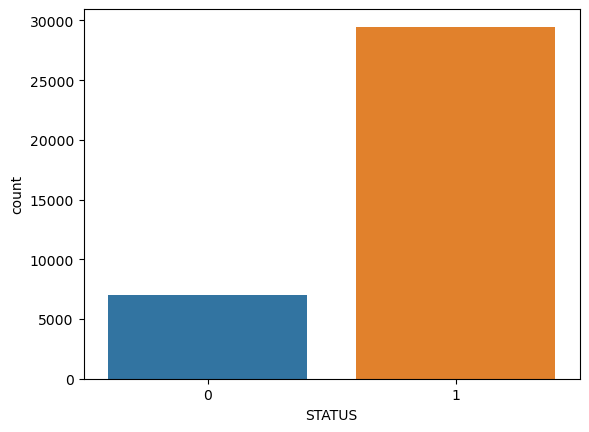

In [32]:
# Checking how target classes are distributed
sns.countplot(df, x='STATUS')

- Above graph shows that our dataset is biased.

In [33]:
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,AGE,YEARS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,CREDIT_HISTORY_MONTHS,STATUS
0,5008804,0,1,1,0,427500,Working,Higher education,Civil marriage,Rented apartment,32,12,1,1,0,0,2,15,1
1,5008805,0,1,1,0,427500,Working,Higher education,Civil marriage,Rented apartment,32,12,1,1,0,0,2,14,1
2,5008806,0,1,1,0,112500,Working,Secondary / secondary special,Married,House / apartment,58,3,1,0,0,0,2,29,0
3,5008808,1,0,1,0,270000,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52,8,1,0,1,1,1,4,0
4,5008809,1,0,1,0,270000,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52,8,1,0,1,1,1,26,0


<AxesSubplot:xlabel='CODE_GENDER', ylabel='count'>

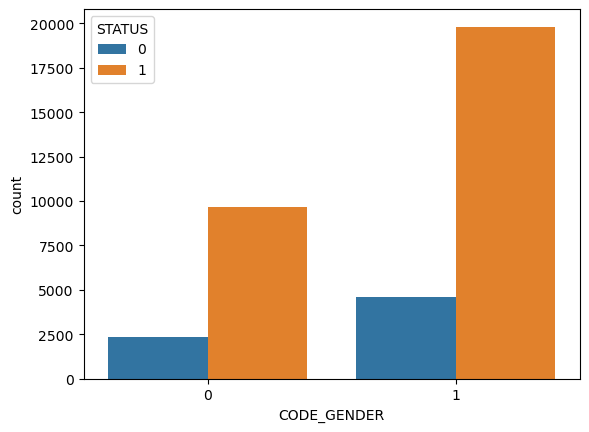

In [34]:
sns.countplot(data=df, x='CODE_GENDER', hue='STATUS')

- By the above graph, we can observe that approval rate is higher for male & female.

<AxesSubplot:xlabel='FLAG_OWN_CAR', ylabel='count'>

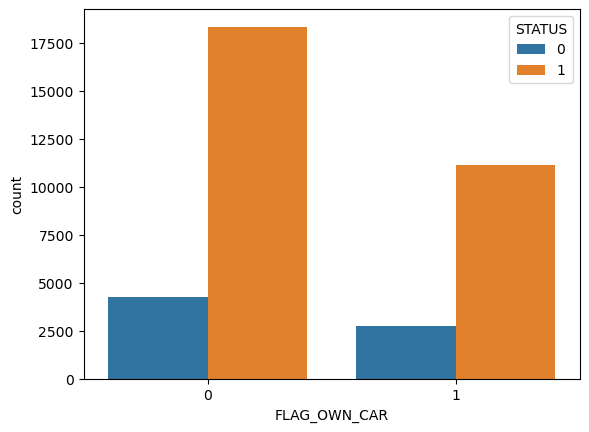

In [35]:
sns.countplot(data=df, x='FLAG_OWN_CAR', hue='STATUS')

- It shows that Male has more cars than female and also approval rate.

<AxesSubplot:xlabel='FLAG_OWN_REALTY', ylabel='count'>

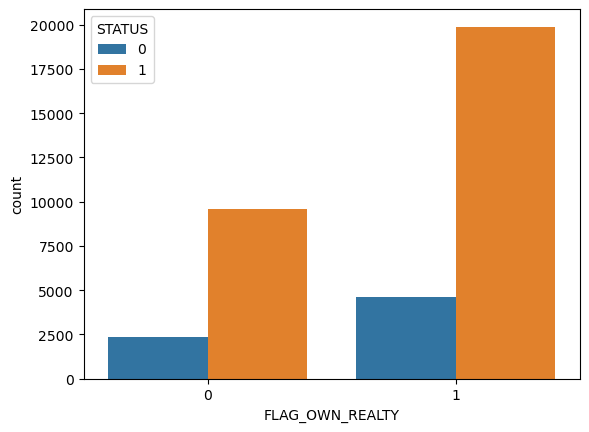

In [36]:
sns.countplot(data=df, x='FLAG_OWN_REALTY', hue='STATUS')

<AxesSubplot:xlabel='CNT_CHILDREN', ylabel='count'>

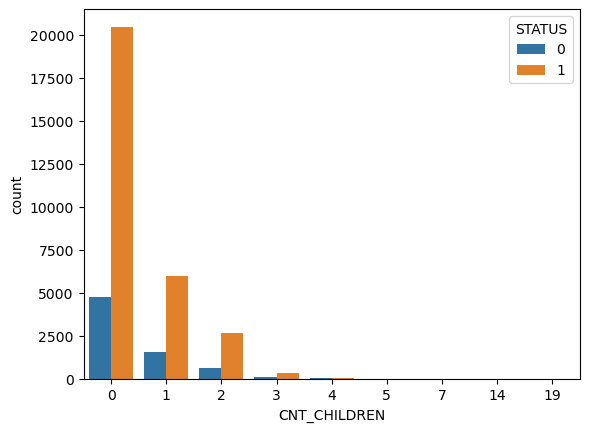

In [37]:
sns.countplot(data=df, x='CNT_CHILDREN', hue='STATUS')

- Above graph depicts, number of children count with respect to approval rate.

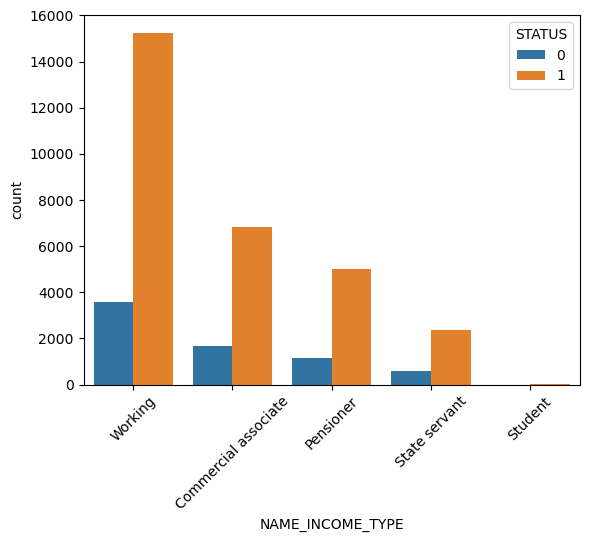

In [38]:
sns.countplot(data=df, x='NAME_INCOME_TYPE', hue='STATUS')
plt.xticks(rotation=45)
plt.show()

- From above graph, we can cleary observe that working customers have high approval rate.

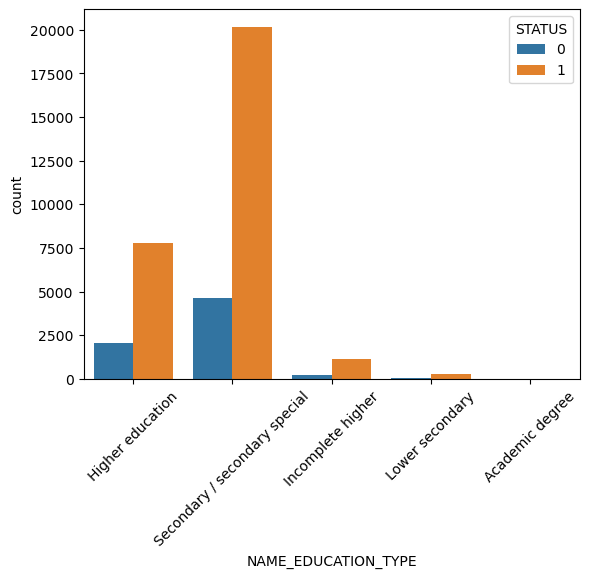

In [39]:
sns.countplot(data=df, x='NAME_EDUCATION_TYPE', hue='STATUS')
plt.xticks(rotation=45)
plt.show()

- Most of the customer are from secondary and higher education type have more approval rate.

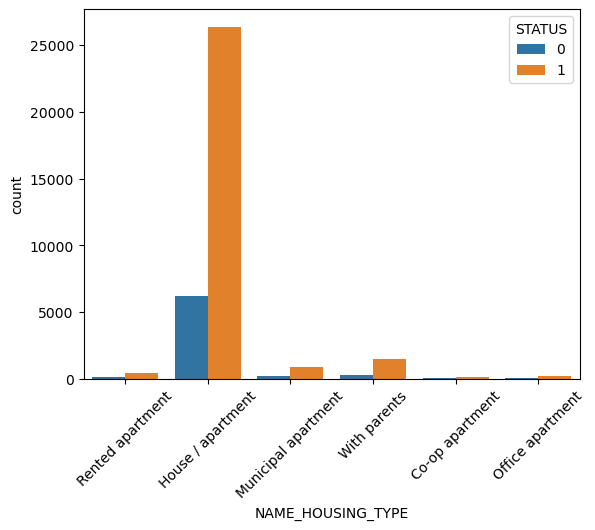

In [40]:
sns.countplot(data=df, x='NAME_HOUSING_TYPE', hue='STATUS')
plt.xticks(rotation=45)
plt.show()

- Above graph shows, the customers with own house or appartment have high approval rate.

<AxesSubplot:xlabel='FLAG_MOBIL', ylabel='count'>

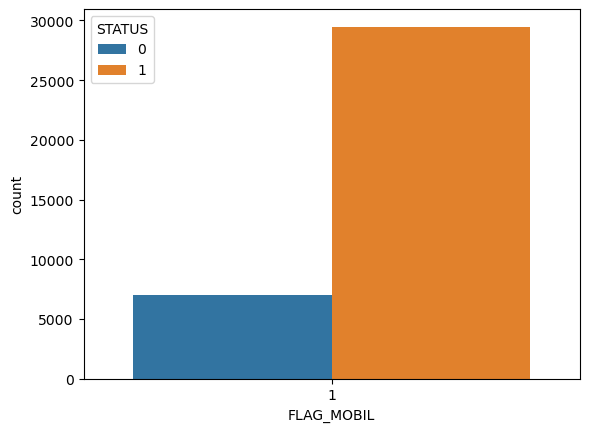

In [41]:
sns.countplot(data=df, x='FLAG_MOBIL', hue='STATUS')


<AxesSubplot:xlabel='FLAG_WORK_PHONE', ylabel='count'>

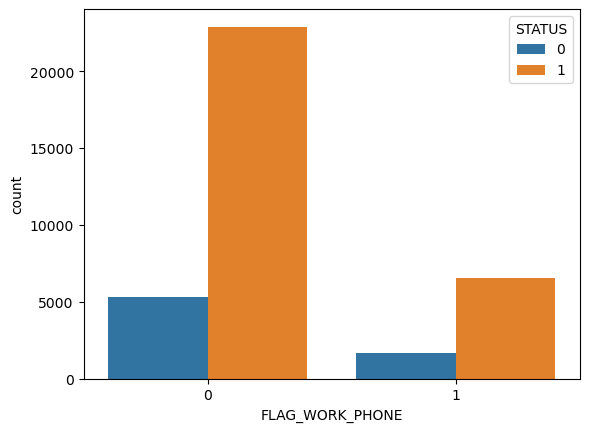

In [42]:
sns.countplot(data=df, x='FLAG_WORK_PHONE', hue='STATUS')

<AxesSubplot:xlabel='FLAG_PHONE', ylabel='count'>

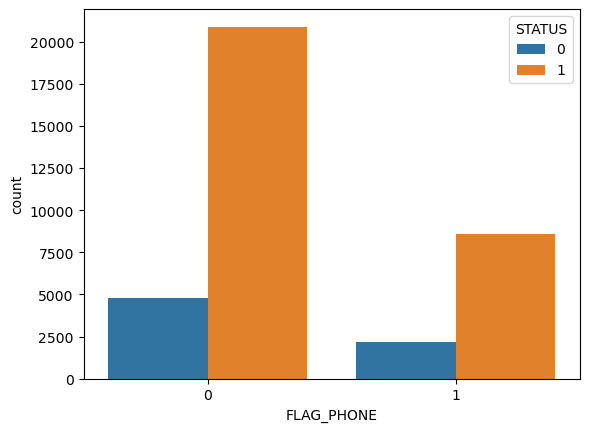

In [43]:
sns.countplot(data=df, x='FLAG_PHONE', hue='STATUS')

<AxesSubplot:xlabel='FLAG_EMAIL', ylabel='count'>

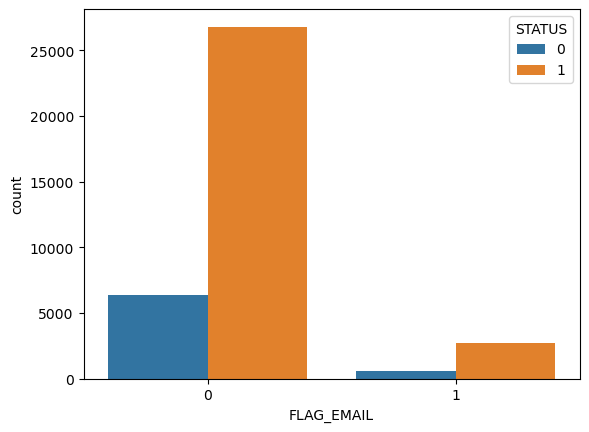

In [44]:
sns.countplot(data=df, x='FLAG_EMAIL', hue='STATUS')

<AxesSubplot:xlabel='CNT_FAM_MEMBERS', ylabel='count'>

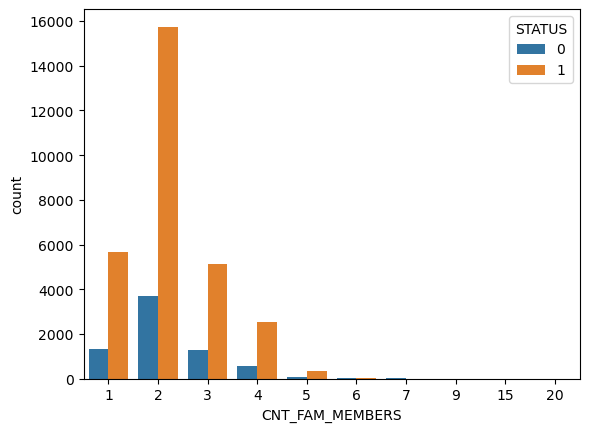

In [45]:
sns.countplot(data=df, x='CNT_FAM_MEMBERS', hue='STATUS')

<AxesSubplot:xlabel='AMT_INCOME_TOTAL', ylabel='Count'>

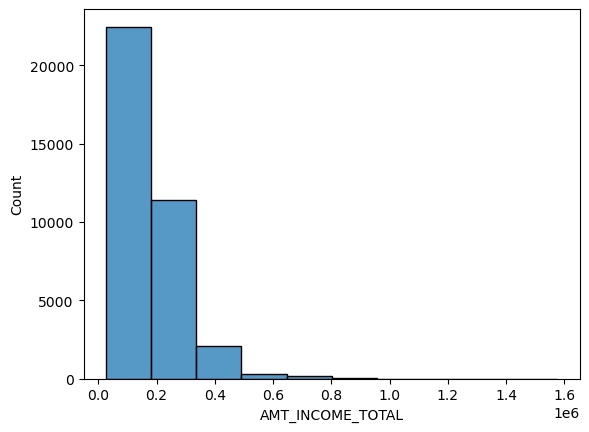

In [46]:
sns.histplot(data=df, x='AMT_INCOME_TOTAL', bins=10)

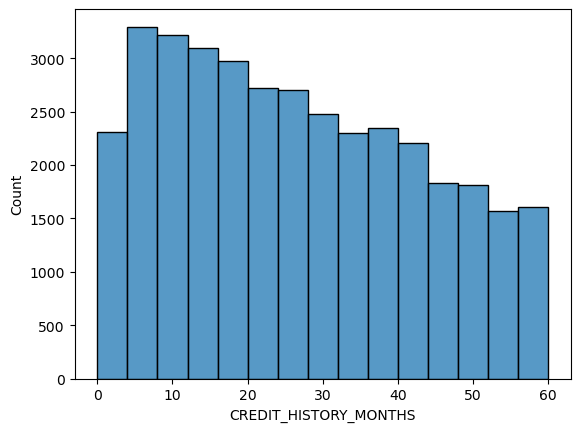

In [47]:
sns.histplot(data=df, x='CREDIT_HISTORY_MONTHS', bins=15)
plt.show()

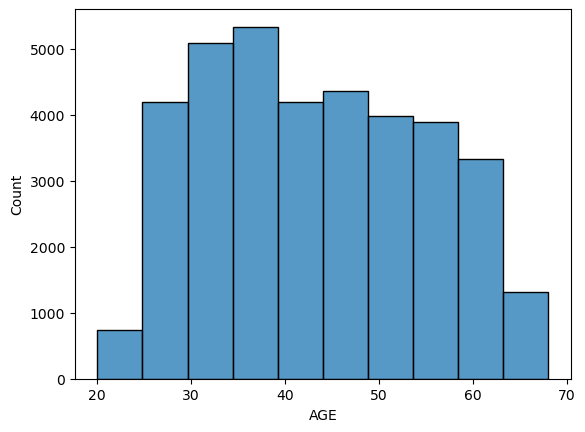

In [48]:
sns.histplot(data=df, x='AGE', bins=10)
plt.show()

# One Hot Encoding

In [49]:
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,AGE,YEARS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,CREDIT_HISTORY_MONTHS,STATUS
0,5008804,0,1,1,0,427500,Working,Higher education,Civil marriage,Rented apartment,32,12,1,1,0,0,2,15,1
1,5008805,0,1,1,0,427500,Working,Higher education,Civil marriage,Rented apartment,32,12,1,1,0,0,2,14,1
2,5008806,0,1,1,0,112500,Working,Secondary / secondary special,Married,House / apartment,58,3,1,0,0,0,2,29,0
3,5008808,1,0,1,0,270000,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52,8,1,0,1,1,1,4,0
4,5008809,1,0,1,0,270000,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52,8,1,0,1,1,1,26,0


In [50]:
df['NAME_EDUCATION_TYPE'].value_counts()

Secondary / secondary special    24777
Higher education                  9864
Incomplete higher                 1410
Lower secondary                    374
Academic degree                     32
Name: NAME_EDUCATION_TYPE, dtype: int64

In [51]:
df['NAME_INCOME_TYPE'].value_counts()

Working                 18819
Commercial associate     8490
Pensioner                6152
State servant            2985
Student                    11
Name: NAME_INCOME_TYPE, dtype: int64

In [52]:
df['NAME_HOUSING_TYPE'].value_counts()

House / apartment      32548
With parents            1776
Municipal apartment     1128
Rented apartment         575
Office apartment         262
Co-op apartment          168
Name: NAME_HOUSING_TYPE, dtype: int64

In [53]:
df['NAME_FAMILY_STATUS'].value_counts()

Married                 25048
Single / not married     4829
Civil marriage           2945
Separated                2103
Widow                    1532
Name: NAME_FAMILY_STATUS, dtype: int64

In [54]:
from sklearn.preprocessing import OneHotEncoder

In [55]:
# List of categorical columns
onehot_encode_cols = ['NAME_INCOME_TYPE', 'NAME_HOUSING_TYPE', 'NAME_FAMILY_STATUS']

In [56]:
df['NAME_EDUCATION_TYPE'].replace({'Lower secondary': 0,  'Secondary / secondary special': 1, 'Incomplete higher': 2, 'Higher education': 3, 'Academic degree': 4}, inplace=True)



In [57]:
df = pd.get_dummies(df, columns = onehot_encode_cols)
df.head()


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_EDUCATION_TYPE,AGE,YEARS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,CREDIT_HISTORY_MONTHS,STATUS,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Working,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow
0,5008804,0,1,1,0,427500,3,32,12,1,1,0,0,2,15,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0
1,5008805,0,1,1,0,427500,3,32,12,1,1,0,0,2,14,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0
2,5008806,0,1,1,0,112500,1,58,3,1,0,0,0,2,29,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0
3,5008808,1,0,1,0,270000,1,52,8,1,0,1,1,1,4,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,5008809,1,0,1,0,270000,1,52,8,1,0,1,1,1,26,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [58]:
df['STATUS'].value_counts()

1    29471
0     6986
Name: STATUS, dtype: int64

In [59]:
df.shape

(36457, 32)

In [60]:
df[['AMT_INCOME_TOTAL', 'AGE', 'YEARS_EMPLOYED', 'CNT_FAM_MEMBERS', 'CREDIT_HISTORY_MONTHS']].corr()

,AMT_INCOME_TOTAL,AGE,YEARS_EMPLOYED,CNT_FAM_MEMBERS,CREDIT_HISTORY_MONTHS
AMT_INCOME_TOTAL,1.000000,-0.067715,-0.168037,0.023750,0.017494
AGE,-0.067715,1.000000,0.624223,-0.303887,0.053939
YEARS_EMPLOYED,-0.168037,0.624223,1.000000,-0.222561,-0.006726
CNT_FAM_MEMBERS,0.023750,-0.303887,-0.222561,1.000000,0.020926
CREDIT_HISTORY_MONTHS,0.017494,0.053939,-0.006726,0.020926,1.000000


<AxesSubplot:>

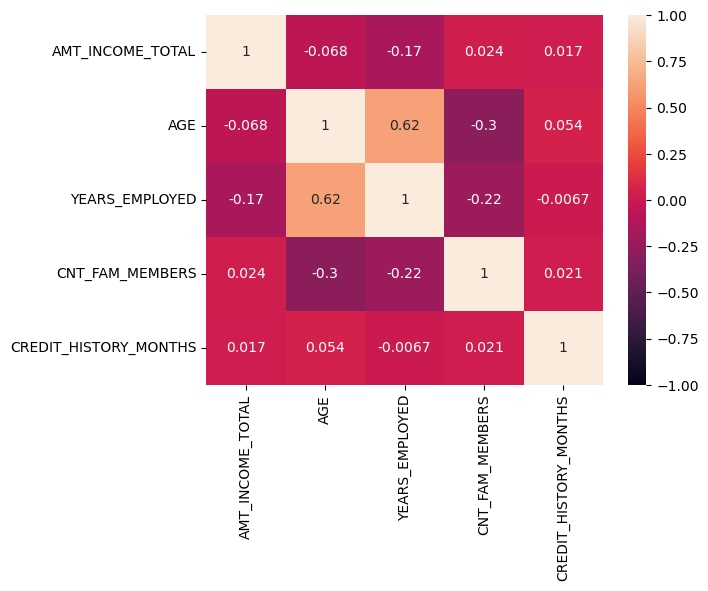

In [61]:
sns.heatmap(df[['AMT_INCOME_TOTAL', 'AGE', 'YEARS_EMPLOYED', 'CNT_FAM_MEMBERS', 'CREDIT_HISTORY_MONTHS']].corr(), annot =True, vmin=-1, vmax=1)


- Age and YearsEmployed are positively correlated

# Train Test Split

In [62]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['ID','CODE_GENDER', 'STATUS'])
y = df['STATUS']

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=143)

# Scaling

In [64]:
# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# fit scaler on training data
# scaler = MinMaxScaler().fit(X_train)
scaler = StandardScaler().fit(X_train)


# transform training data
X_train_scaled = scaler.transform(X_train)

# transform testing dataabs
X_test_scaled = scaler.transform(X_test)

In [65]:
X_train_scaled.shape, X_test_scaled.shape

((29165, 29), (7292, 29))

In [66]:
y_train.shape, y_test.shape

((29165,), (7292,))

In [67]:
y_train.value_counts(normalize=True)*100

1    80.836619
0    19.163381
Name: STATUS, dtype: float64

# Downsampling

In [68]:
from imblearn.under_sampling import TomekLinks
undersample = TomekLinks()
X_train_scaled, y_train  = undersample.fit_resample(X_train_scaled, y_train)

In [69]:
X_train_scaled.shape, y_train.shape

((27701, 29), (27701,))

In [70]:
y_train.value_counts(normalize=True)*100

1    79.823833
0    20.176167
Name: STATUS, dtype: float64

# Modelling

In [71]:
# Import LogisticRegression
from sklearn.linear_model import LogisticRegression 
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# XG Boost

In [72]:
from xgboost import XGBClassifier

#  fit model to training data
model = XGBClassifier()
model.fit(X_train_scaled, y_train)

# train_predict = model.predict(xTrain)
y_pred = model.predict(X_test_scaled)

test_acc = accuracy_score(y_test, y_pred)
# train_acc = accuracy_score(yTrain, train_predict)
print('Test score:',test_acc)

[18:27:42] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Test score: 0.8165112452002194


In [73]:
# Print the confusion matrix of the logreg model
confusion_matrix(y_test,y_pred)

array([[ 164, 1233],
       [ 105, 5790]])

# KNN

In [86]:

knn = KNeighborsClassifier(n_neighbors=15)

knn.fit(X_train_scaled, y_train)

# train_predict = knn.predict(xTrain)
y_pred = knn.predict(X_test_scaled)

test_acc = accuracy_score(y_test, y_pred)
# train_acc = accuracy_score(yTrain, train_predict)
print('Test score:',test_acc)
# print(i,'Train score:',train_acc,'Test score:',test_acc)

Test score: 0.8092430060340099


In [87]:
# Print the confusion matrix of the logreg model
confusion_matrix(y_test,y_pred)

array([[ 123, 1274],
       [ 117, 5778]])

# Gradient Boost

In [98]:

clf = GradientBoostingClassifier(random_state=0)
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)

test_acc = accuracy_score(y_test, y_pred)
print('Test score:',test_acc)


Test score: 0.8084201865057598


In [99]:
# Print the confusion matrix of the model
confusion_matrix(y_test,y_pred)

array([[  25, 1372],
       [  25, 5870]])

In [100]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.50      0.02      0.03      1397
           1       0.81      1.00      0.89      5895

    accuracy                           0.81      7292
   macro avg       0.66      0.51      0.46      7292
weighted avg       0.75      0.81      0.73      7292



# RandomForest

In [102]:
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)


test_acc = accuracy_score(y_test, y_pred)


In [103]:
# Print the confusion matrix of the model
confusion_matrix(y_test,y_pred)

array([[ 430,  967],
       [ 408, 5487]])

In [104]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.31      0.38      1397
           1       0.85      0.93      0.89      5895

    accuracy                           0.81      7292
   macro avg       0.68      0.62      0.64      7292
weighted avg       0.79      0.81      0.79      7292



# Decision Tree

In [74]:

dtc = DecisionTreeClassifier(max_depth = 10 ,random_state = 0)
dtc.fit(X_train_scaled, y_train)

# train_pred = dtc.predict(xTrain)
#train_acc.append(score(train_pred, yTrain))

y_pred = dtc.predict(X_test_scaled)
#test_acc.append(score(test_pred, yTest))
test_acc = accuracy_score(y_test, y_pred)
# train_acc = accuracy_score(y_test, y_pred)
print('Test score:',test_acc)

Test score: 0.8062260010970927


In [75]:
# Print the confusion matrix of the logreg model
confusion_matrix(y_test,y_pred)

array([[ 100, 1297],
       [ 116, 5779]])

## Hyperparameter Tunning

In [76]:
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

In [77]:
clf = GridSearchCV(estimator=DecisionTreeClassifier(), 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [78]:
best_clf = clf.fit(X_train_scaled, y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


In [79]:
best_clf.best_estimator_

DecisionTreeClassifier(max_depth=3, min_samples_leaf=100)

In [80]:
best_DecisionTree = DecisionTreeClassifier(max_depth=3, min_samples_leaf=100)

In [81]:
best_DecisionTree.fit(X_train_scaled, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=100)

In [82]:
y_pred = best_DecisionTree.predict(X_test_scaled)


In [83]:
best_DecisionTree.score(X_test_scaled,y_test)

0.8088315962698848

In [84]:
confusion_matrix(y_test,y_pred)

array([[  34, 1363],
       [  31, 5864]])

In [85]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.02      0.05      1397
           1       0.81      0.99      0.89      5895

    accuracy                           0.81      7292
   macro avg       0.67      0.51      0.47      7292
weighted avg       0.76      0.81      0.73      7292



#### From all the above models we got good score in XGBoost

# THE END